In [1]:
from scipy.io.wavfile import read, write
import torchaudio
import torch
from librosa.util import normalize
from librosa.filters import mel as librosa_mel_fn
import numpy as np
import librosa
import librosa.display
from tqdm import tqdm
import os
import soundfile as sf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
MAX_WAV_VALUE = 32768.0

def load_wav(full_path):
    sampling_rate, data = read(full_path)
    return data, sampling_rate

def dynamic_range_compression(x, C=1, clip_val=1e-5):
    return np.log(np.clip(x, a_min=clip_val, a_max=None) * C)

def dynamic_range_decompression(x, C=1):
    return np.exp(x) / C

def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)

def dynamic_range_decompression_torch(x, C=1):
    return torch.exp(x) / C

def spectral_normalize_torch(magnitudes):
    output = dynamic_range_compression_torch(magnitudes)
    return output

def spectral_de_normalize_torch(magnitudes):
    output = dynamic_range_decompression_torch(magnitudes)
    return output

mel_basis = {}
hann_window = {}

def mel_spectrogram(y, n_fft, num_mels, sampling_rate, hop_size, win_size, fmin, fmax, center=False):
    if torch.min(y) < -1.:
        print('min value is ', torch.min(y))
    if torch.max(y) > 1.:
        print('max value is ', torch.max(y))

    global mel_basis, hann_window
    if fmax not in mel_basis:
        mel = librosa_mel_fn(sr=sampling_rate, n_fft=n_fft, n_mels=num_mels, fmin=fmin, fmax=fmax)
        mel_basis[str(fmax)+'_'+str(y.device)] = torch.from_numpy(mel).float().to(y.device)
        hann_window[str(y.device)] = torch.hann_window(win_size).to(y.device)

    y = torch.nn.functional.pad(y.unsqueeze(1), (int((n_fft-hop_size)/2), int((n_fft-hop_size)/2)), mode='reflect')
    y = y.squeeze(1)

    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[str(y.device)],
                      center=center, pad_mode='reflect', normalized=False, onesided=True)

    spec = torch.sqrt(spec.pow(2).sum(-1)+(1e-9))

    spec = torch.matmul(mel_basis[str(fmax)+'_'+str(y.device)], spec)
    spec = spectral_normalize_torch(spec)

    return spec

In [ ]:
data_path = "/blob/v-yuancwang/audio_editing_data/audiocaps/wav"
WAV_LENGTH = 16000 * 10 - 128
with open("/home/v-yuancwang/AudioEditing/metadatas/audiocaps_train_metadata.jsonl", "r") as f:
    lines = f.readlines()
lines = [eval(line) for line in lines]
root_data = []
for line in tqdm(lines[:]):
    file_name, text = line['file_name'], line['text']
    words = list(text.split(" "))
    if len(words) < 12 and 'and' not in words and 'while' not in words and 'as' not in words and 'with' not in words and "then" not in words and "followed" not in words:
        root_data.append({'file_name': file_name, 'text': text})
print(len(root_data))
print(root_data[: 10])

In [36]:
def genaudio1(wav1, wav2):
    wav1 = wav1[: min(len(wav1), len(wav2))]
    wav2 = wav2[: min(len(wav1), len(wav2))]
    e1 = np.sqrt(np.mean((wav1**2)))
    e2 = np.sqrt(np.mean((wav2**2)))
    wav3 = (wav1 * e2 + wav2 * e1) / (e1 + e2)
    wav3 = np.clip(wav3, -1, 1)
    return wav3, 'type1'

def genaudio2(id1, id2):
    wav1 = wav1[: min(len(wav1), len(wav2))]
    wav2 = wav2[: min(len(wav1), len(wav2))]
    wav2_d = len(wav2)
    wav2 = np.pad(wav2, (int(22050 * np.random.uniform(2.5, 5)), 0), 'constant', constant_values=(0, 0))
    wav2 = wav2[: wav2_d]
    e1 = np.sqrt(np.mean((wav1**2)))
    e2 = np.sqrt(np.mean((wav2**2)))
    wav3 = (wav1 * e2 + wav2 * e1) / (e1 + e2)
    wav3 = np.clip(wav3, -1, 1)
    return wav3, 'type2'

def genaudio3(id1, id2):
    wav1 = wav1[: min(len(wav1), len(wav2))]
    wav2 = wav2[: min(len(wav1), len(wav2))]
    wav2_d = len(wav2)
    wav2 = np.pad(wav2, (int(22050 * np.random.uniform(2.5, 5)), 0), 'constant', constant_values=(0, 0))
    wav2 = wav2[: wav2_d]
    wav1_d = int(22050 * np.random.uniform(5, 6))
    if len(wav1) - wav1_d >= 0:
        wav1 = np.append(wav1[:wav1_d], wav1[wav1_d: ] * np.linspace(1, 0, num=len(wav1) - wav1_d))
    e1 = np.sqrt(np.mean((wav1**2)))
    e2 = np.sqrt(np.mean((wav2**2)))
    wav3 = (wav1 * e2 + wav2 * e1) / (e1 + e2)
    wav3 = np.clip(wav3, -1, 1)
    return wav3, 'type3'

In [37]:
save_path = "/blob/v-yuancwang/audio_editing_data/add"

In [38]:
metadatas = []
for i in tqdm(range(len(root_data))[:]):
    id1 = i
    id2 = id1
    while(id2 == id1):
        id2 = np.random.randint(0, len(root_data))
    name1, name2 = root_data[id1]["file_name"], root_data[id2]["file_name"]
    text1, text2 = root_data[id1]["text"], root_data[id2]["text"]

    wav1, _ = librosa.load(os.path.join(data_path, root_data[id1]["file_name"]), sr=16000)
    wav2, _ = librosa.load(os.path.join(data_path, root_data[id2]["file_name"]), sr=16000)
    
    wav3, type_class = genaudio1(wav1, wav2)
    x3 = torch.FloatTensor(wav3)
    x3 = mel_spectrogram(x3.unsqueeze(0), n_fft=1024, num_mels=80, sampling_rate=16000,
                    hop_size=256, win_size=1024, fmin=0, fmax=8000)
    spec3 = x3.cpu().numpy()[0]
    # print(spec3.shape)

    wav3 = wav3 * MAX_WAV_VALUE
    wav3 = wav3.astype('int16')

    wav_name = 'audiocaps' + type_class + 'gen' + str(i) + '.wav'
    spec_name = 'audiocaps' + type_class + 'gen' + str(i) + '.npy'

    write(os.path.join(save_path, "wav", wav_name), 16000, wav3)
    np.save(os.path.join(save_path, "mel", spec_name), spec3)
    metadatas.append((name1, name2, wav_name, text1, text2, type_class))

with open("/home/v-yuancwang/AudioEditing/metadatas/audiocaps_add.txt", "w") as f:
    for name1, name2, wav_name, text1, text2, type_class in metadatas:
        f.write(wav_name  + "   " + name1 + "   " + name2  + "   "  +  text1  + "   " +  text2  + "   " +  type_class + "\n")

100%|██████████| 11061/11061 [44:54<00:00,  4.10it/s] 


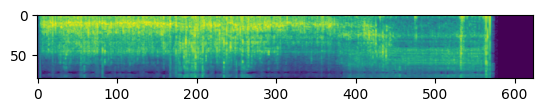

In [26]:
plt.imshow(spec1)

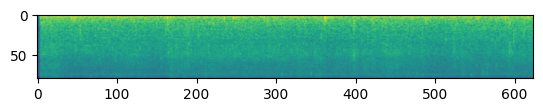

In [27]:
plt.imshow(spec2)

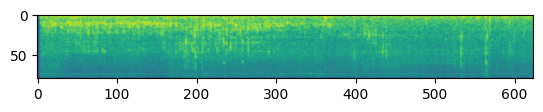

In [28]:
plt.imshow(spec3)